In [0]:
# cost of misclassification is high 
# p of pair of questions , setting thresold
# no strict latency concerns
# interpretability is partially important 

# **Type of machine learning problem--- binary classification**

# **Performance metrics--- logloss**

# **Exploratory Data Analysis**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls 
import os
import gc

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/quora_data'

train.csv


In [0]:
df = pd.read_csv('/content/drive/My Drive/quora_data/train.csv')
print("Number of data points ",df.shape[0])

Number of data points  404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


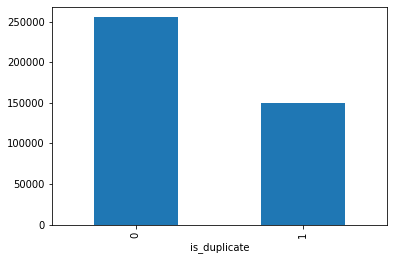

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


**Number of unique questions**

In [0]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))

qs_morethan_onetime = np.sum(qids.value_counts()>1)

print('no of unique questions that appear more than 1:{}({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('max no of times a single question is repeated:{}\n'.format(max(qids.value_counts())))
q_vals = qids.value_counts()
q_vals= q_vals.values

no of unique questions that appear more than 1:111780(20.77953945937505%)

max no of times a single question is repeated:157



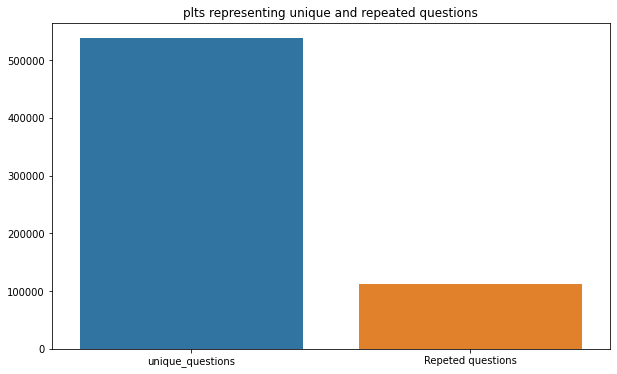

In [0]:
x=["unique_questions","Repeted questions"]
y=[unique_qs, qs_morethan_onetime]

plt.figure(figsize=(10,6))
plt.title("plts representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

**Checking duplicates**

In [0]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('no of duplicate questions',(pair_duplicates).shape[0]-df.shape[0])

no of duplicate questions 0


**No of occurance of each question**

Maximum number of times a single question is repeated: 157



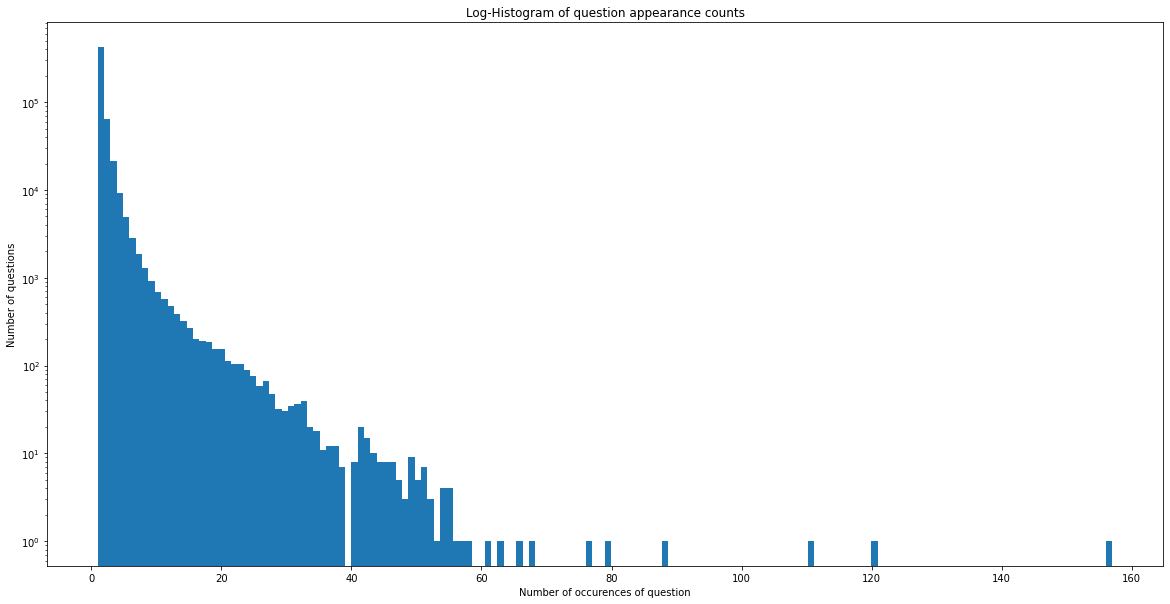

In [0]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

**checking null values**

In [0]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


In [0]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic feature extraction(before cleaning )**

let us construct a few features like:


*   freq_qid1
*   freq_qid2
*   q1len
*   q2len
*   q1_n_words
*   q2_n_words
*   word_Common
*   word_Total
*   word_share
*   freq_qid1+freq_qid2
*   freq_qid1-freq_qid2

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
  df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
  df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
  df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
  df['q1len'] = df['question1'].str.len()
  df['q2len'] = df['question2'].str.len()
  df['q1_n_words'] = df['question1'].apply(lambda row:len(row.split(" ")))
  df['q2_n_words'] = df['question2'].apply(lambda row:len(row.split(" ")))

  # @staticmethod
  def normalized_word_Common(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
  df['word_Common'] = df.apply(normalized_word_Common, axis=1)

  def normalized_word_Total(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1)+len(w2)
  df['word_Total'] = df.apply(normalized_word_Total, axis=1)

  def normalized_word_share(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1)+len(w2))
  df['word_share'] = df.apply(normalized_word_share, axis=1)

  df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
  df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

  df.to_csv("df_fe_without_preprocessing_train.csv", index=False);

df.head()
  

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
# continued

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


Feature: share_word

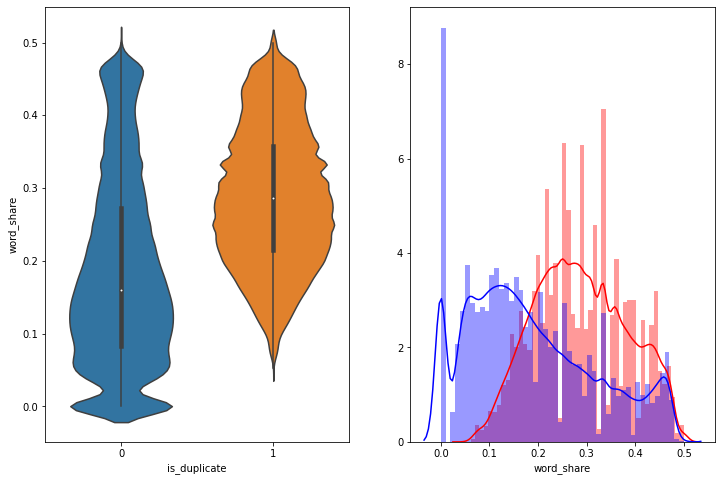

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

Feature: word_common


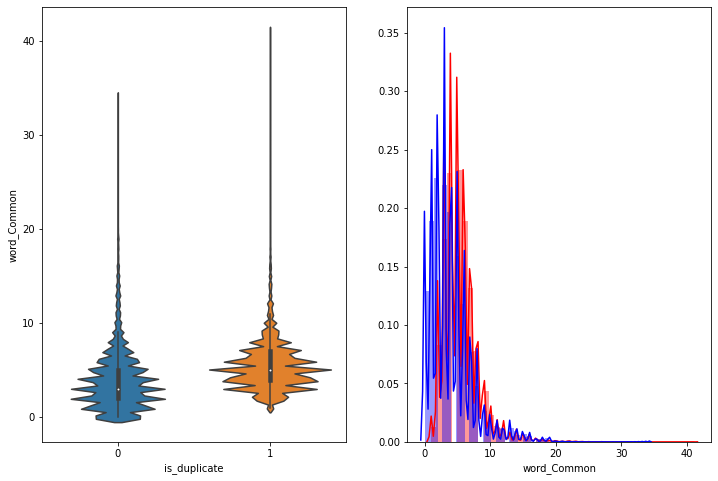

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**Preprocessing of text**


*   removing html tags
*   removing punctuations
*   performing stemming
*   removing stopwords
*   expanding contractions



In [0]:
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [0]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144791 sha256=d1daa794354016976c0c1c023424cef278b01057cb690c1da14d67c19511ae70
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [0]:
import nltk
nltk.download("popular")


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)

  porter = PorterStemmer()
  pattern = re.compile('\W')

  if type(x) == type(''):
    x = re.sub(pattern, ' ',x)

  if type(x) == type(''):
    x = porter.stem(x)
    example = BeautifulSoup(x)
    x = example1.get_text()

  return x


